In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import matplotlib.pyplot as plt
from functools import partial
from jax_tqdm import scan_tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

from plotly_resampler import register_plotly_resampler, FigureWidgetResampler

import pandas as pd

from algorithms.utils import restore_state, restore_state_multi_agent

import numpy as np

import jax
import jax.numpy as jnp
# jax.config.update("jax_enable_x64", True)


2025-03-01 19:24:36.972900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740853476.991888  345700 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740853476.996909  345700 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.multi_agent.env import RECEnv
# from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    env = RECEnv(params, battery_type)
    return env

In [5]:
from ernestogym.envs_jax.multi_agent.utils import parameter_generator

In [6]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/multi_agent/world_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

# num_iter = 8760 * 28

params

{'num_battery_agents': 2,
 'num_passive_houses': 0,
 'batteries': [{'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 288.0,
    'temp_ambient': 298.15,
    'nominal_cost': 3000.0},
   'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
    'current': {'low': -180.0, 'high': 60.0},
    'power': {'low': -71712.0, 'high': 23904.0},
    'temperature': {'low': 273.15, 'high': 323.15},
    'temp_ambient': {'low': 273.15, 'high': 323.15},
    'soc': {'low': 0.2, 'high': 1.0},
    'soh': {'low': 0.6, 'high': 1.0}},
   'init': {'voltage': 310.8,
    'current': 0.0,
    'power': 0.0,
    'temperature': 293.15,
    'temp_ambient': 293.15,
    'soc': 0.2,
    'soh': 1.0}},
  {'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 2

In [7]:
num_iter = 8760 * 10 #* len(params['demands_battery_houses'][0]['demand_profiles'])

# Testing

In [8]:
logs = {}

## PPO

In [9]:
@partial(jax.jit, static_argnums=(0, 1, 2, 3))
def test_ppo(env:RECEnv, networks_batteries, network_rec, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv_batteries, env_state, rng, next_profile_index = runner_state

        pi, _ = networks_batteries(obsv_batteries)
        #deterministic action
        actions_batteries = pi.mode()
        actions_batteries = actions_batteries.squeeze(axis=-1)
        # jax.debug.print('act bat {x}', x=actions_batteries)


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        rec_obsv = obsv[env.rec_agent]

        pi, _ = network_rec(rec_obsv)
        actions_rec = pi.mean()
        jax.debug.print('{x}', x=pi.concentration)
        # actions_rec = jnp.zeros(env.num_battery_agents)

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec
        info['dones'] = jax.tree.map(lambda x, y : jnp.logical_or(x, y), done_first, done_second)

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [10]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250301_192244_lr_0.001_tot_timesteps_3504000_anneal_rl_True_normal_multiagent_non_esploso'

networks_batteries, network_rec, config, params_training, val_info = restore_state_multi_agent(directory)

In [11]:
config

{'ACTIVATION': 'swish',
 'ANNEAL_LR': True,
 'BATTERY_ACTION_SPACE_SIZE': 1,
 'BATTERY_OBSERVATION_SPACE_SIZE': 10,
 'CLIP_EPS': 0.2,
 'DEBUG': False,
 'ENT_COEF': 0.01,
 'ENV_NAME': None,
 'ENV_TYPE': 'normal',
 'GAE_LAMBDA': 0.95,
 'GAMMA': 0.99,
 'LOGISTIC_FUNCTION_TO_ACTOR': False,
 'LR': 0.001,
 'MAX_GRAD_NORM': 0.5,
 'MINIBATCH_SIZE': 1024,
 'NETWORK': 'actor_critic',
 'NET_ARCH': (64, 32, 16),
 'NORMALIZE_ADVANTAGES': True,
 'NORMALIZE_ENV': False,
 'NUM_BATTERY_AGENTS': 2,
 'NUM_ENVS': 4,
 'NUM_MINIBATCHES': 32,
 'NUM_STEPS': 8192,
 'NUM_UPDATES': 106,
 'PASSIVE_HOUSES': False,
 'REC_ACTION_SPACE_SIZE': 2,
 'REC_INPUT_NETWORK_SIZE': 12,
 'TOTAL_TIMESTEPS': 3504000,
 'UPDATE_EPOCHS': 10,
 'VF_COEF': 0.5}

In [12]:
env = my_env_creator(params, battery_type)

In [13]:
info = test_ppo(env, networks_batteries, network_rec, num_iter, jax.random.PRNGKey(51))
logs['ppo'] = info

[0.7603958  0.76054597]


Running for 87,600 iterations:   0%|          | 0/87600 [00:00<?, ?it/s]

[0.76023   0.7605066]
[0.7605461 0.7604527]
[0.7604415  0.76054585]
[0.7601917 0.760541 ]
[0.7601345 0.7647175]
[5.7832203 5.667548 ]
[2.9743392 3.2321146]
[4.6396227 4.467751 ]
[6.3101134 6.2028804]
[29.291744 24.890734]
[61.36904 72.90559]
[9.328397 9.38332 ]
[13.569201  9.693252]
[3.4509284 1.0238646]
[1.9252945 1.3991427]
[2.6162894 2.5678668]
[0.7930173 0.7555966]
[1.01177   0.7906725]
[1.5639405 1.577418 ]
[0.86001664 0.81066245]
[3.0297067 3.8383799]
[2.7978964 2.96769  ]
[0.93231946 0.87992984]
[0.76040906 0.75649863]
[0.7605056 0.7561051]
[0.76052594 0.75957817]
[0.7604898 0.7588148]
[0.7601528  0.75739795]
[1.5993028 1.2608209]
[3.8131597 3.6793075]
[4.3923097 4.6245604]
[6.5471296 6.0616508]
[17.743147 16.561241]
[53.193813 62.31228 ]
[58.136734 68.93734 ]
[21.04304  21.778246]
[13.826724 11.79018 ]
[4.1730585 1.9693737]
[0.7605465  0.75948334]
[3.4848034 3.1656027]
[1.8331726 1.5765145]
[1.1232185 1.0746342]
[0.8047236 0.8911269]
[0.7600642 0.7581652]
[0.7605465 0.7604911]


In [14]:
info

{'actions_batteries': Array([[-0.46063915, -0.12914367],
        [-0.3612524 , -0.13159724],
        [-0.3321757 , -0.13248533],
        ...,
        [-1.1601102 , -0.08118878],
        [-0.30653456, -0.09577163],
        [-0.2647042 , -0.08130541]], dtype=float32),
 'actions_rec': Array([[0.49995068, 0.5000494 ],
        [0.49990907, 0.50009096],
        [0.50003076, 0.49996933],
        ...,
        [0.4999276 , 0.50007236],
        [0.5010792 , 0.49892074],
        [0.50108576, 0.4989142 ]], dtype=float32),
 'buy_prices': Array([[0.000138  , 0.000138  ],
        [0.00013327, 0.00013327],
        [0.00012678, 0.00012678],
        ...,
        [0.00013768, 0.00013768],
        [0.00013561, 0.00013561],
        [0.0001293 , 0.0001293 ]], dtype=float32),
 'demands': Array([[ 766.,  358.],
        [ 630.,  361.],
        [ 452.,  360.],
        ...,
        [1829.,  155.],
        [ 569.,  228.],
        [  74.,  152.]], dtype=float32),
 'dones': {'REC_agent': Array([False, False, False,

## Recurrent PPO

In [15]:
# @partial(jax.jit, static_argnums=(0, 2, 3))
# def test_recurrent_ppo(env: MicroGridEnv, env_params, network, num_iter, rng):
#
#     rng, _rng = jax.random.split(rng)
#
#     env_params = env.eval(env_params)
#
#     obsv, env_state = env.reset(_rng, env_params)
#
#     env_params = env_params.replace(test_profile=env_params.test_profile+1)
#
#     act_state, cri_state = network.get_initial_lstm_state()
#
#     @scan_tqdm(num_iter, print_rate=num_iter // 100)
#     def _env_step(runner_state, unused):
#         obsv, env_state, env_params, act_state, rng = runner_state
#
#         pi, _, act_state, _ = network(obsv, act_state, cri_state)
#
#         #deterministic action
#         action = pi.mode()
#
#         rng, _rng = jax.random.split(rng)
#         obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)
#
#         env_params = jax.lax.cond(done,
#                                   lambda : env_params.replace(test_profile=env_params.test_profile+1),
#                                   lambda : env_params)
#
#         runner_state = (obsv, env_state, env_params, act_state, rng)
#         return runner_state, (info, action)
#
#     runner_state = (obsv, env_state, env_params, act_state, rng)
#
#     runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))
#
#     return info

In [16]:
# directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250227_144145_lr_0.001_tot_timesteps_3504000_anneal_rl_True_normal_recurrent_actor_critic'
#
# network, config, params_training, val_info = restore_state(directory)
#
# assert config['ENV_TYPE'] == env_type

In [17]:
# config

In [18]:
# info, actions = test_recurrent_ppo(env, env_params, network, num_iter, jax.random.PRNGKey(51))
# info['actions'] = actions.flatten()
# logs['recurrent_ppo'] = info

## Random

In [19]:
@partial(jax.jit, static_argnums=(0, 1))
def test_random(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        env_state, rng, next_profile_index = runner_state

        rng, _rng = jax.random.split(rng)
        actions_batteries = jax.random.uniform(_rng, shape=(env.num_battery_agents,), minval=env.i_min_action, maxval=env.i_max_action)

        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        runner_state = (env_state, rng, next_profile_index)
        return runner_state, info

    runner_state = (env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [20]:
info = test_random(env, num_iter, jax.random.PRNGKey(51))
logs['random'] = info

Running for 87,600 iterations:   0%|          | 0/87600 [00:00<?, ?it/s]

## Only market

In [21]:
@partial(jax.jit, static_argnums=(0, 1))
def test_only_market(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        env_state, rng, next_profile_index = runner_state

        rng, _rng = jax.random.split(rng)
        actions_batteries = jnp.zeros((env.num_battery_agents,))

        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        runner_state = (env_state, rng, next_profile_index)
        return runner_state, info

    runner_state = (env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [22]:
info = test_only_market(env, num_iter, jax.random.PRNGKey(51))
logs['only_market'] = info

Running for 87,600 iterations:   0%|          | 0/87600 [00:00<?, ?it/s]

## Battery first

In [23]:
@partial(jax.jit, static_argnums=(0, 1))
def test_battery_first(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv_batteries, env_state, rng, next_profile_index = runner_state

        demand = obsv_batteries[:, env._obs_battery_agents_idx['demand']]
        generation = obsv_batteries[:, env._obs_battery_agents_idx['generation']]

        actions_batteries = (generation - demand) / env_state.battery_states.electrical_state.v


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [24]:
info = test_battery_first(env, num_iter, jax.random.PRNGKey(51))
logs['battery_first'] = info

Running for 87,600 iterations:   0%|          | 0/87600 [00:00<?, ?it/s]

In [25]:
jax.tree.map(lambda x: x.shape, logs)

{'battery_first': {'actions_batteries': (87600, 2),
  'actions_rec': (87600, 2),
  'buy_prices': (87600, 2),
  'demands': (87600, 2),
  'generations': (87600, 2),
  'norm_reward': {'r_clipping': (87600, 2),
   'r_deg': (87600, 2),
   'r_op': (87600, 2),
   'r_trad': (87600, 2)},
  'pure_reward': {'r_clipping': (87600, 2),
   'r_deg': (87600, 2),
   'r_op': (87600, 2),
   'r_trad': (87600, 2)},
  'r_glob': (87600, 2),
  'r_tot': (87600, 2),
  'rec_reward': (87600,),
  'self_consumption': (87600,),
  'sell_prices': (87600, 2),
  'soc': (87600, 2),
  'soh': (87600, 2),
  'tot_incentives': (87600,),
  'weig_reward': {'r_clipping': (87600, 2),
   'r_deg': (87600, 2),
   'r_op': (87600, 2),
   'r_trad': (87600, 2)}},
 'only_market': {'actions_batteries': (87600, 2),
  'actions_rec': (87600, 2),
  'buy_prices': (87600, 2),
  'demands': (87600, 2),
  'generations': (87600, 2),
  'norm_reward': {'r_clipping': (87600, 2),
   'r_deg': (87600, 2),
   'r_op': (87600, 2),
   'r_trad': (87600, 2)},
 

# Plotting

In [26]:
logs = jax.tree.map(lambda x : np.asarray(x), logs)

algs = ['random', 'only_market', 'battery_first', 'ppo']        #, 'recurrent_ppo']
colors = {alg: col for alg, col in zip(algs, plotly.colors.sample_colorscale('rainbow', len(algs)))}

In [27]:
logs['ppo']['actions_rec'][28109]

array([0.5078594, 0.4921405], dtype=float32)

In [28]:
np.sum(np.isnan(logs['ppo']['actions_rec']).any(axis=1))


0

In [29]:
# logs['ppo']['actions_rec']

In [30]:
jax.tree.map(lambda x: jnp.isnan(x).any(), logs['ppo'])

{'actions_batteries': Array(False, dtype=bool),
 'actions_rec': Array(False, dtype=bool),
 'buy_prices': Array(False, dtype=bool),
 'demands': Array(False, dtype=bool),
 'dones': {'REC_agent': Array(False, dtype=bool),
  '__all__': Array(False, dtype=bool),
  'battery_agent_0': Array(False, dtype=bool),
  'battery_agent_1': Array(False, dtype=bool)},
 'generations': Array(False, dtype=bool),
 'norm_reward': {'r_clipping': Array(False, dtype=bool),
  'r_deg': Array(False, dtype=bool),
  'r_op': Array(False, dtype=bool),
  'r_trad': Array(False, dtype=bool)},
 'pure_reward': {'r_clipping': Array(False, dtype=bool),
  'r_deg': Array(False, dtype=bool),
  'r_op': Array(False, dtype=bool),
  'r_trad': Array(False, dtype=bool)},
 'r_glob': Array(False, dtype=bool),
 'r_tot': Array(False, dtype=bool),
 'rec_reward': Array(False, dtype=bool),
 'self_consumption': Array(False, dtype=bool),
 'sell_prices': Array(False, dtype=bool),
 'soc': Array(False, dtype=bool),
 'soh': Array(False, dtype=boo

In [31]:
print('Tot self consumption')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['self_consumption'])}')

print('Tot reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['r_tot'])}')

print('Tot glob reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['r_glob'])}')

print('Tot trad reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['weig_reward']['r_trad'])}')

print('Tot clipping reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['weig_reward']['r_clipping'])}')

print('Tot rec reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['rec_reward'])}')

Tot self consumption
	random: 110227192.0
	only_market: 1227335.0
	battery_first: 3976309.0
	ppo: 1607682.75
Tot reward
	random: -349184.15625
	only_market: -8591.67578125
	battery_first: -20041.970703125
	ppo: -9554.298828125
Tot glob reward
	random: 13590.462890625
	only_market: 149.69358825683594
	battery_first: 489.7218017578125
	ppo: 196.5560760498047
Tot trad reward
	random: -74860.078125
	only_market: -4390.6474609375
	battery_first: 902.8736572265625
	ppo: -3575.13916015625
Tot clipping reward
	random: -251647.703125
	only_market: 0.0
	battery_first: -14039.009765625
	ppo: -1602.4290771484375
Tot rec reward
	random: 110227192.0
	only_market: 1227335.0
	battery_first: 3976309.0
	ppo: 1607856.875


In [32]:
logs['ppo']['self_consumption']

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [33]:
ac = logs['ppo']['actions_batteries']

ac.min(), ac.max(), ac.mean(), np.var(ac)

(-2.0936809, 1.2141117, -0.06894574, 0.09890189)

In [34]:
def plot_external_data_matplotlib(demand, generation, sell_prices, buy_prices, start=0, length_max=None):

    if length_max is None:
        length_max = max(len(demand), len(generation), len(sell_prices), len(buy_prices))

    fig = plt.figure(figsize=(15, 20))

    ax1 = fig.add_subplot(2, 1, 1)

    ax1.plot(demand[start:start + length_max], label='demand')
    ax1.plot(generation[start:start + length_max], label='generation')
    ax1.legend()
    ax1.set_ylabel('W')

    sell_prices *= 1000000
    buy_prices *= 1000000

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(sell_prices[start:start + length_max], label='sell_price')
    ax2.plot(buy_prices[start:start + length_max], label='buy_price')
    ax2.legend()
    ax2.set_ylabel('€/MWh')

    plt.show()

# def plot_external_data_plotly(demand, generation, sell_prices, buy_prices, time_step):
#
#     n_points = max(len(demand), len(generation), len(sell_prices), len(buy_prices))
#
#     time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
#     fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Power demand and generation', 'Market prices'])
#
#     # Add first time series
#     fig.add_trace(go.Scatter(x=time, y=demand, mode='lines', legendgroup='group1', name='demand'), row=1, col=1)
#     fig.add_trace(go.Scatter(x=time, y=generation, mode='lines', legendgroup='group1', name='generation'), row=1, col=1)
#
#     # Add second time series
#     fig.add_trace(go.Scatter(x=time, y=sell_prices*1000000, mode='lines', legendgroup='group2', name='Selling prices'), row=2, col=1)
#     fig.add_trace(go.Scatter(x=time, y=buy_prices*1000000, mode='lines', legendgroup='group2', name='Buying prices'), row=2, col=1)
#
#     # Format x-axis to show only month & day
#     fig.update_layout(
#         title='Synchronized Zoom with Month/Day Formatting',
#         xaxis=dict(tickformat='%b %d', showticklabels=True),   # Apply to main x-axis
#         xaxis2=dict(tickformat='%b %d', showticklabels=True),  # Apply to second subplot
#         yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
#         yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
#         height=800,
#         width=1000,
#         legend_tracegroupgap=20
#     )
#
#     # fig.update_layout(
#     # legends=[
#     #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
#     #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
#     # ]
#     # )
#
#     fig.update_layout(
#         legend_tracegroupgap=400
#     )
#
#
#     fig.show()


def plot_external_data_plotly(demand, generation, sell_prices, buy_prices, time_step):

    n_points = max(len(demand), len(generation), len(sell_prices), len(buy_prices))

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Power demand and generation', 'Market prices']))

    # Add first time series
    fig.add_trace(go.Scatter(x=time, y=demand, mode='lines', legend='legend1', name='demand'), row=1, col=1)
    fig.add_trace(go.Scatter(x=time, y=generation, mode='lines', legend='legend1', name='generation'), row=1, col=1)

    # Add second time series
    fig.add_trace(go.Scatter(x=time, y=sell_prices*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    # Format x-axis to show only month & day
    fig.update_layout(
        title='Synchronized Zoom with Month/Day Formatting',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),   # Apply to main x-axis
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),  # Apply to second subplot
        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        height=800,
        width=1000,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)


def plot_data_plotly(demand, generation, sell_prices, buy_prices, log, algs, time_step, reward_type='weig_reward', cumulative=True):

    n_points = max(len(demand), len(generation), len(sell_prices), len(buy_prices))

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=8, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Actions']))

    # Add first time series
    fig.add_trace(go.Scatter(x=time, y=demand, mode='lines', legend='legend1', name='demand'), row=1, col=1)
    fig.add_trace(go.Scatter(x=time, y=generation, mode='lines', legend='legend1', name='generation'), row=1, col=1)

    # Add second time series
    fig.add_trace(go.Scatter(x=time, y=sell_prices*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'])
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'])
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'])
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']

    for alg in algs:
        fig.add_trace(go.Scatter(x=time, y=log[alg]['soc'], line=dict(color=colors[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_tot'], line=dict(color=colors[alg]), mode='lines', legend='legend4', name=alg), row=4, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'], line=dict(color=colors[alg]), mode='lines', legend='legend5', name=alg), row=5, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_deg'], line=dict(color=colors[alg]), mode='lines', legend='legend6', name=alg), row=6, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_clipping'], line=dict(color=colors[alg]), mode='lines', legend='legend7', name=alg), row=7, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['actions'], line=dict(color=colors[alg]), mode='lines', legend='legend8', name=alg), row=8, col=1)




    # Format x-axis to show only month & day
    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis6=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis8=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis6=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis8=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=3000,
        width=1000,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)

In [35]:
def plot_ext_data_and_reward_plotly(demand, generation, sell_prices, buy_prices, log, algs, time_step, cumulative=True):

    n_points = max(len(demand), len(generation), len(sell_prices), len(buy_prices))

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'Total reward']))#, 'Actions'])

    # Add first time series
    fig.add_trace(go.Scattergl(x=time, y=demand, mode='lines', legend='legend1', name='demand'), row=1, col=1)
    fig.add_trace(go.Scattergl(x=time, y=generation, mode='lines', legend='legend1', name='generation'), row=1, col=1)

    # Add second time series
    fig.add_trace(go.Scattergl(x=time, y=sell_prices*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scattergl(x=time, y=buy_prices*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']

    for alg in algs:
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_tot'], line=dict(color=colors[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scattergl(x=time, y=log[alg]['actions'], line=dict(color=colors[alg]), mode='lines', legend='legend7', name=alg), row=4, col=1)




    # Format x-axis to show only month & day
    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=2000,
        width=1000,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)

def plot_details_reward_plotly(log, algs, time_step, reward_type='weig_reward', cumulative=True):

    n_points = len(log[algs[0]]['r_tot'])

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Actions']))

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'])
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'])
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'])
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']

    for alg in algs:
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_tot'], line=dict(color=colors[alg]), mode='lines', legend='legend1', name=alg), row=1, col=1)
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_trad'], line=dict(color=colors[alg]), mode='lines', legend='legend2', name=alg), row=2, col=1)
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_deg'], line=dict(color=colors[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_clipping'], line=dict(color=colors[alg]), mode='lines', legend='legend4', name=alg), row=4, col=1)
        fig.add_trace(go.Scattergl(x=time, y=log[alg]['actions'], line=dict(color=colors[alg]), mode='lines', legend='legend5', name=alg), row=5, col=1)




    # Format x-axis to show only month & day
    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=2000,
        width=1000,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)

In [36]:
logs['ppo']['soc'].shape, logs['ppo']['r_tot'].shape

((87600, 2), (87600, 2))

In [37]:
# plot_external_data_matplotlib(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], start=1000, length_max=200)
algs_to_plot = ['only_market', 'battery_first', 'ppo', 'recurrent_ppo']

plot_data_plotly(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], logs, algs_to_plot, env.params.env_step, reward_type='weig_reward')

KeyError: 'demand'

In [28]:
# plot_ext_data_and_reward_plotly(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], logs, algs_to_plot, env.params.env_step)

In [29]:
# plot_details_reward_plotly(logs, algs_to_plot, env.params.env_step)

In [30]:
summary = {}

for alg in algs:
    summary[alg] = {'mean_soc': np.mean(logs[alg]['soc']),
                    'r_tot': np.sum(logs[alg]['r_tot']),
                    # 'norm_reward': {'r_trad': np.sum(logs[alg]['norm_reward']['r_trad']),
                    #                 # 'r_op': np.sum(logs[alg]['norm_reward']['r_op']),
                    #                 'r_deg': np.sum(logs[alg]['norm_reward']['r_deg']),
                    #                 'r_clipping': np.sum(logs[alg]['norm_reward']['r_clipping'])},
                    'weig_reward': {'r_trad': np.sum(logs[alg]['weig_reward']['r_trad']),
                                    # 'r_op': np.sum(logs[alg]['weig_reward']['r_op']),
                                    'r_deg': np.sum(logs[alg]['weig_reward']['r_deg']),
                                    'r_clipping': np.sum(logs[alg]['weig_reward']['r_clipping'])},
                    'pure_reward': {'r_trad': np.sum(logs[alg]['pure_reward']['r_trad']),
                                    # 'r_op': np.sum(logs[alg]['pure_reward']['r_op']),
                                    'r_deg': np.sum(logs[alg]['pure_reward']['r_deg']),
                                    'r_clipping': np.sum(logs[alg]['pure_reward']['r_clipping'])},
                    'mean_action': np.mean(logs[alg]['actions']),
                    'max_action': np.max(logs[alg]['actions']),
                    'min_action': np.min(logs[alg]['actions']),
                    'variance_action': np.var(logs[alg]['actions']),
                    'final_soh': logs[alg]['soh'][-1],}

flatten_summary = {}

for alg in algs:
    flatten_summary[alg] = {}
    for key in summary[alg].keys():
        if isinstance(summary[alg][key], dict):
            flatten_summary[alg].update([(key+'.'+subkey, summary[alg][key][subkey]) for subkey in summary[alg][key].keys()])
        else:
            flatten_summary[alg][key] = summary[alg][key]


In [31]:
df = pd.DataFrame.from_dict(flatten_summary, orient='index')
pd.set_option('display.max_columns', None)
df

,mean_soc,r_tot,weig_reward.r_trad,weig_reward.r_deg,weig_reward.r_clipping,pure_reward.r_trad,pure_reward.r_deg,pure_reward.r_clipping,mean_action,max_action,min_action,variance_action,final_soh
random,0.598552,-501489.218750,-102757.203125,-50527.925781,-348204.093750,-51281.417969,-50527.925781,-904401472.0,-0.050749,47.999886,-47.999977,767.323303,0.845574
only_market,0.200000,-12039.757812,-5948.747070,-6091.011230,0.000000,-3229.083740,-6091.011230,0.0,0.000000,0.000000,0.000000,0.000000,0.970995
battery_first,0.761144,-32342.226562,-1731.479614,-10344.604492,-20266.142578,-1142.564697,-10344.604492,-52719604.0,0.291413,5.812455,-9.776364,3.654005,0.952736
ppo,0.217549,-12644.393555,-4515.269531,-6484.864258,-1644.259888,-2528.104248,-6484.864258,-4263321.5,-0.050175,0.456598,-0.795225,0.079188,0.969126
recurrent_ppo,0.220387,-11387.691406,-3963.334229,-6548.811523,-875.544312,-2251.621582,-6548.811523,-2302751.5,-0.027100,1.007216,-1.188642,0.176985,0.968848


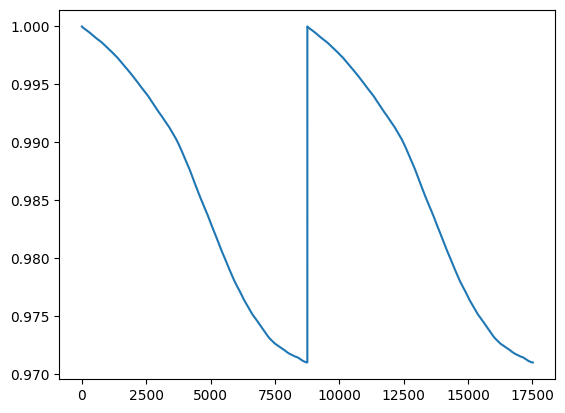

In [32]:
plt.plot(logs['only_market']['soh'][:int(len(logs['ppo']['soh'])/14)])